In [342]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [343]:
from tqdm.notebook import tqdm

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go

import torch

import sys
sys.path.append('../../modules')
from env.gridworld import VanillaGridWorld, GridWorldWithWallsAndTraps
from algo.dp import PolicyIteration
from policy import EpsilonGreedyPolicy

from algo.on_policy_prediction_with_approximation import *

In [426]:
env = VanillaGridWorld(num_rows=20, num_cols=20, start_coord=(0, 0), end_coord=(19, 19), mode=0)

In [427]:
policy = EpsilonGreedyPolicy(q=np.zeros(env.action_space_shape), epsilon=0)

In [428]:
discount_factor = 0.87

In [429]:
pi = PolicyIteration(env=env, policy=policy, discount_factor=discount_factor, truncate_pe=True, pe_tol=None, conv_tol=1e-16)
pi.run(max_iterations=1000, which_tqdm='notebook')

Running DP policy iteration for at most 1000 iterations ...


Result: Convergence reached at iteration 40


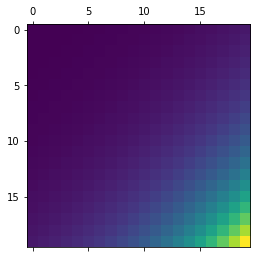

In [431]:
plt.matshow(pi.q.max(axis=-1))
plt.show()

## On-policy distribution

In [491]:
state_counts = np.zeros(env.state_space_shape, dtype=np.float64)

for _ in tqdm(range(1000), leave=False):
    
    env.reset()
    while True:
        
        s = env.current_coord
        state_counts[s] += 1
        
        a = policy.act(s)
        s_prime, r = env.step(a)
        
        if env.is_episode_terminated(): 
            state_counts[env.current_coord] += 1
            break
            
mu = state_counts / np.sum(state_counts)

In [543]:
fig = go.Figure(data=[go.Surface(
    z=mu,
    colorscale='jet', 
    cmid=0.01
)])

fig.update_layout(title='On-policy distribution', autosize=False,
                  scene = dict(
                    xaxis_title='S1',
                    yaxis_title='S2',
                    zaxis_title='Probability'),
                  width=500, height=500,
                  margin=dict(l=0, r=0, b=0, t=90))

# fig.write_html("on_policy_distribution.html")

## Training

In [434]:
# np.random.seed(42)

In [435]:
# tabular_mc = MCPredictor(
#     env=env, 
#     policy=policy, 
#     discount_factor=discount_factor, 
#     vrepr=Table(env.state_space_shape), 
#     vtrue=pi.q.max(axis=-1), 
#     on_policy_dist=mu
# )
# tabular_mc_errors = tabular_mc.run(1000)

In [436]:
# gradient_mc_linear = MCPredictor(
#     env=env, 
#     policy=policy, 
#     discount_factor=discount_factor, 
#     vrepr=LinearApproximator(
#         lr=1e-2, 
#         fc=LinearFeatureConstructor(num_raw_features=2, lowers=(0, 0), uppers=(19, 19)), 
#         state_space_shape=env.state_space_shape
#     ), 
#     vtrue=pi.q.max(axis=-1), 
#     on_policy_dist=mu
# )
# gradient_mc_linear_errors = gradient_mc_linear.run(1000)

In [437]:
# gradient_mc_polynomial = MCPredictor(
#     env=env, 
#     policy=policy, 
#     discount_factor=discount_factor, 
#     vrepr=LinearApproximator(
#         lr=1e-2, 
#         fc=PolynomialFeatureContructor(num_raw_features=2, order=4, lowers=(0, 0), uppers=(19, 19)), 
#         state_space_shape=env.state_space_shape
#     ), 
#     vtrue=pi.q.max(axis=-1), 
#     on_policy_dist=mu
# )
# gradient_mc_polynomial_errors = gradient_mc_polynomial.run(1000)

In [438]:
# gradient_mc_fourier = MCPredictor(
#     env=env, 
#     policy=policy, 
#     discount_factor=discount_factor, 
#     vrepr=LinearApproximator(
#         lr=1e-2, 
#         fc=FourierFeatureConstructor(num_raw_features=2, order=4, lowers=(0, 0), uppers=(19, 19)), 
#         state_space_shape=env.state_space_shape
#     ), 
#     vtrue=pi.q.max(axis=-1), 
#     on_policy_dist=mu
# )
# gradient_mc_fourier_errors = gradient_mc_fourier.run(1000)

In [439]:
# with open('errors.json', 'w+') as json_f:
#     json.dump({
#         'tabular_mc_errors' : tabular_mc_errors,
#         'gradient_mc_linear_errors' : gradient_mc_linear_errors,
#         'gradient_mc_polynomial_errors' : gradient_mc_polynomial_errors,
#         'gradient_mc_fourier_errors' : gradient_mc_fourier_errors
#     }, json_f)

In [443]:
with open('errors.json', 'r') as json_f:
    errors_dict = json.load(json_f)
    tabular_mc_errors = errors_dict['tabular_mc_errors']
    gradient_mc_linear_errors = errors_dict['gradient_mc_linear_errors']
    gradient_mc_polynomial_errors = errors_dict['gradient_mc_polynomial_errors']
    gradient_mc_fourier_errors = errors_dict['gradient_mc_fourier_errors']

In [444]:
def plot_errors(errors, label):
    plt.plot(range(1, len(errors)+1), errors, linewidth=1.5, alpha=1, label=label)

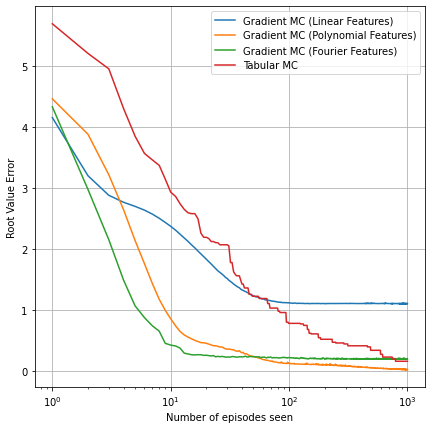

In [544]:
plt.figure(figsize=(7, 7))

plot_errors(gradient_mc_linear_errors, label='Gradient MC (Linear Features)')
plot_errors(gradient_mc_polynomial_errors, label='Gradient MC (Polynomial Features)')
plot_errors(gradient_mc_fourier_errors, label='Gradient MC (Fourier Features)')
plot_errors(tabular_mc_errors, label='Tabular MC')

plt.xlabel('Number of episodes seen'); plt.ylabel('Root Value Error')
plt.legend()

plt.xscale('log')
plt.grid()

plt.savefig('errors_over_time.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

## Visualize learned value functions

In [446]:
num_contours = 50

In [447]:
xs, ys = np.arange(env.state_space_shape[0]), np.arange(env.state_space_shape[1])
xxs, yys = np.meshgrid(xs, ys)

In [464]:
def common():
   
    ax = plt.gca()

    ax.set_xticks(np.arange(0, 20, 3))
    ax.set_yticks(np.arange(0, 20, 3))
    ax.set_zlim(-9, 0)
    
    ax.set_xlabel(r'$s_1$')
    ax.set_ylabel(r'$s_2$')
    ax.set_zlabel('Value')
    
    ax.view_init(elev=30, azim=240)

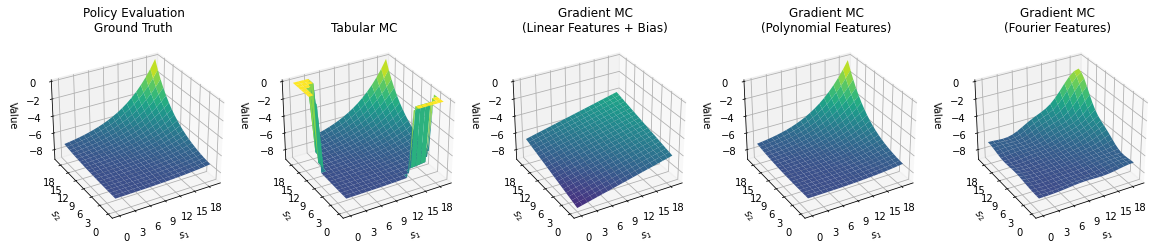

In [465]:
fig = plt.figure(figsize=(20, 20/4))

ax = fig.add_subplot(151, projection='3d')
ax.plot_surface(xxs, yys, pi.q.max(axis=-1), cmap='viridis', vmax=0, vmin=-10)
ax.set_title('Policy Evaluation\nGround Truth')
common()

ax = fig.add_subplot(152, projection='3d')
ax.plot_surface(xxs, yys, tabular_mc.vrepr.v, cmap='viridis', vmax=0, vmin=-10)
ax.set_title('Tabular MC')
common()

ax = fig.add_subplot(153, projection='3d')
ax.plot_surface(xxs, yys, gradient_mc_linear.vrepr.v, cmap='viridis', vmax=0, vmin=-10)
ax.set_title('Gradient MC\n(Linear Features + Bias)')
common()

ax = fig.add_subplot(154, projection='3d')
ax.plot_surface(xxs, yys, gradient_mc_polynomial.vrepr.v, cmap='viridis', vmax=0, vmin=-10)
ax.set_title('Gradient MC\n(Polynomial Features)')
common()

ax = fig.add_subplot(155, projection='3d')
ax.plot_surface(xxs, yys, gradient_mc_fourier.vrepr.v, cmap='viridis', vmax=0, vmin=-10)
ax.set_title('Gradient MC\n(Fourier Features)')
common()

# plt.tight_layout()
plt.savefig('learned_values.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)